# Getting Started in TINerator

Thanks for trying out TINerator. This notebook provides a soft introduction to the module, and is intended to demonstrate the workflow at a high level. More advanced capabilities can be found in the documentation.

## Workflow Overview

The workflow will follow this pattern:

0. Import the TINerator module
1. Prepare the DEM that you wish to mesh
    - Read the DEM from disk
    - [optional] Clip the DEM using a watershed boundary shapefile
    - [optional] Reproject the DEM from a lat-lon into a meter-based CRS
    - [optional] Post-process the DEM using a pit-filling algorithm
2. Prepare the feature that you wish to refine the mesh around
    - This can be a flowline shapefile, or
    - Watershed delineation can be performed to extract the flowline from the DEM
3. Generate a triangulation from the DEM
4. Extrude the triangulation into the subsurface with layering
5. [optional] Add material attributes to the extruded mesh
6. [optional] Define face sets / point sets / element sets to act as "regions"
7. Write the mesh to disk

## 0. Import the TINerator module

In [1]:
import tinerator as tin

## 1. Prepare the DEM that you wish to mesh

TINerator comes with some built-in datasets. We'll use the New Mexico dataset for this example.
It contains the following paths to files:

| class attribute | description |
| --------------- | ----------- |
| `dem` | path to a DEM tile |
| `watershed_boundary` | path to the watershed boundary shapefile |
| `flowline` | path to the flowline shapefile |

First, load the DEM from disk:

Raster<data.shape=(2373, 2575), extent=[-107.70482, 36.29657, -107.46639, 36.5163], CRS="NAD83">

NoData value: -3.4028230607370965e+38

CRS: GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4269"]]


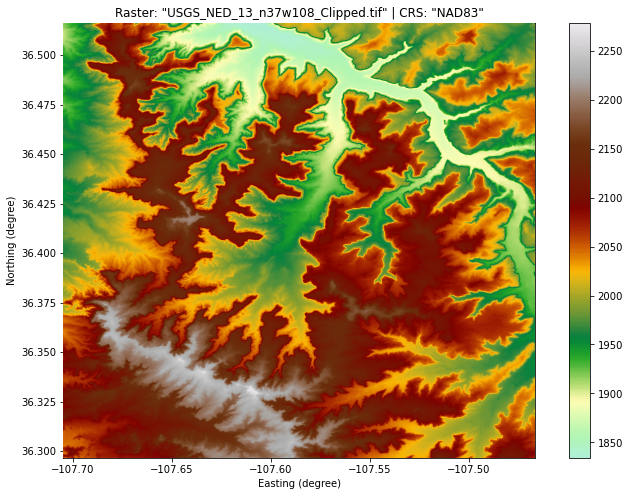

In [2]:
data = tin.ExampleData.NewMexico

dem = tin.gis.load_raster(data.dem)
print(dem)
print(f'\nNoData value: {dem.no_data_value}\n')
print(f'CRS: {dem.crs}')

dem.plot()

Next, load the watershed boundary and clip the DEM with it:

Geometry<"Polygon", shapes=1, crs="NAD83", properties=1>

CRS: GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4269"]]

Shapefile properties: {'properties': {'id': [None]}, 'metadata': {'schema': OrderedDict([('id', 'int:10')])}}



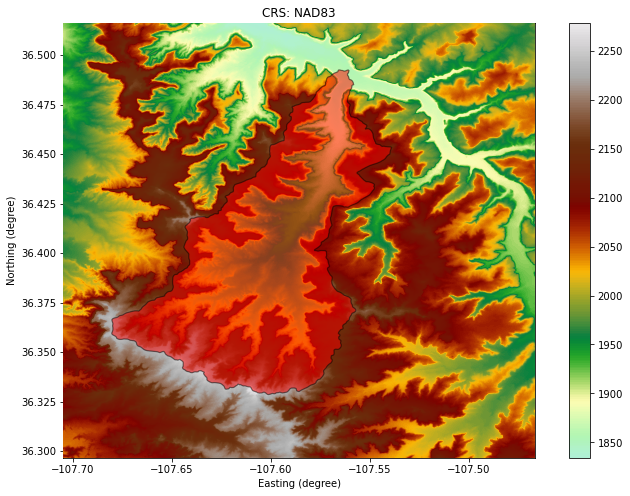

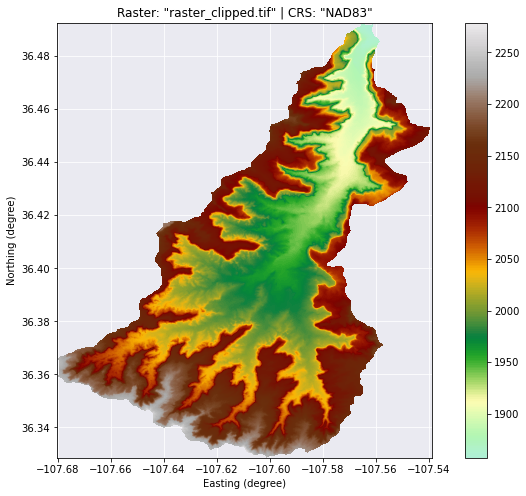

In [3]:
ws_bnd = tin.gis.load_shapefile(data.watershed_boundary)
print(ws_bnd)
print(f"\nCRS: {ws_bnd.crs}\n")
print(f"Shapefile properties: {ws_bnd.properties}\n")

# We can add the `layers` keyword to plot to add
# multiple objects to plot at once
ws_bnd.plot(layers=[dem])

# Clip the DEM!
dem = tin.gis.clip_raster(dem, ws_bnd)
dem.plot()

Next, let's reproject the raster into meters. Meters are the units that Amanzi-ATS expects, and moving out of lat-lon helps to avoid floating-point overflow errors when triangulating.

In [4]:
print(f"Units before reprojecting: {dem.units}")

dem = tin.gis.reproject_raster(dem, "epsg:32112")

print(f"Units after reprojecting: {dem.units}")

Units before reprojecting: degree


Units after reprojecting: metre


Finally, use `fill_depressions` to fill pits and flats:

In [5]:
# Note that fill_depressions operates in-place: it doesn't return a new Raster object
dem.fill_depressions()

# Optionally, we can also save the post-processed DEM:
# dem.save("dem_clipped_reprojected_pit-filled.tif")

### 2. Prepare the feature that you wish to refine the mesh around

When creating a triangulation, a distance field is created, taking a copy of the raster and filling
every cell with the Euclidean distance to the refinement feature. The distance field then informs how the triangulation algorithm should refine triangles.

The refinement feature is a Geometry object loaded from a shapefile or created by the user. Consequently, the refinement feature can be a collection of points, lines, or polygons.

In the case of flowlines, they will be lines. We can either read these from a shapefile on disk, or create them using the built-in watershed delineation method.

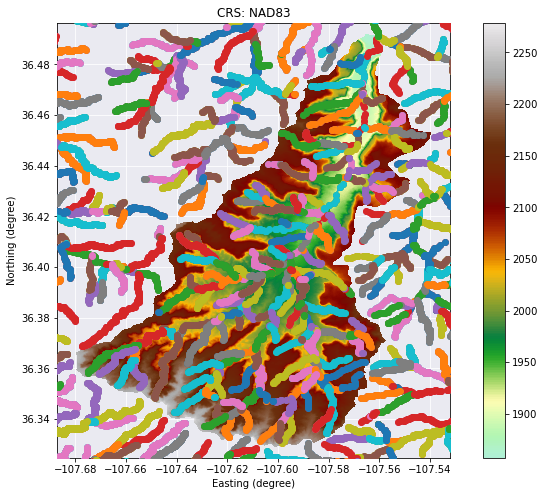

In [6]:
flowlines_shapefile = tin.gis.load_shapefile(data.flowline)
flowlines_shapefile.plot(layers=[dem])

### 2.1 Watershed delineation

Watershed delineation is performed using the `tinerator.gis.watershed_delineation` function.

There are a few optional parameters:

- `method`: by default, uses the D8 algorithm. Also supports D4, Quinn, Rho8, Rho4, and more.
- `threshold`: a flow accumulation raster is generated from running watershed delineation algorithm. As flow is simulated to the cells in the raster, each cell will have a value containing the amount of flow into it. `threshold` "cuts off" cells with a value below this and keeps cells with a value above it, where all kept cells form the flowline.

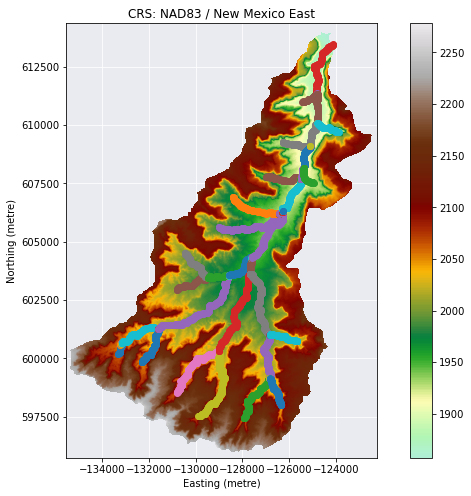

In [7]:
flowlines_wsdelin = tin.gis.watershed_delineation(dem)

# flowlines_wsdelin = tin.gis.watershed_delineation(dem, threshold=15000., method='D4')

flowlines_wsdelin.plot(layers=[dem])

### 3. Generate a triangulation from the DEM

The core of the triangulation algorithm are the parameters:

- `min_edge_length`: The minimum edge length for created triangles.
- `max_edge_length`: The maximum edge length for created triangles.
- `scaling_type`: Can be "relative" or "absolute". If absolute, then the edge length parameters will interpreted as meters (or whatever the units of the DEM are). If "relative", then the edge length parameters will be considered *percent of the DEM extent*.

Recall that the refinement feature (the flowlines above) create a distance field internally. That distance field is normalized to `[0., 1.]`.

Where the distance field is `0.`, triangles will have an edge length of `min_edge_length`. Where the distance field is `1.`, triangles will have an edge length of `max_edge_length`. Distance field values between `[0., 1.]` will linearly interpolate the edge lengths.

Various triangulation kernels are supported:

- JIGSAW
- MeshPy (based on Triangle)
- Gmsh

In [8]:
mesh_tri = tin.meshing.triangulate(
    dem,
    min_edge_length = 0.005,
    max_edge_length = 0.1,
    scaling_type = "relative",
    refinement_feature = flowlines_wsdelin,
    method = "jigsaw",
)

mesh_tri.view(window_size=(400,400))

### 4. Extrude the triangulation into the subsurface with layering

### 5. [optional] Add material attributes to the extruded mesh

### 6. [optional] Define face sets / point sets / element sets to act as "regions"

### 7. Write the mesh to disk

In [9]:
#gis_triang = tin.gis.vectorize_triangulation(mesh_tri)
#gis_triang.save('triangulation.shp')

# ("layer type", layer data, sublayers, material_id)

layers = [
    ("constant", 500., 4, 1),
    ("constant", 200., 1, 2),
    ("snapped", 1000., 3, [3,2,1])
]

volume_mesh = tin.meshing.extrude_mesh(
    mesh_tri, 
    layers
)

volume_mesh.view(window_size=(800,800))

# TODO: add attributes
# TODO: add facesets

volume_mesh.save("vol_mesh.vtk")
volume_mesh.save("vol_mesh.exo")
volume_mesh.save("vol_mesh.inp")


You are using exodus.py v 1.20.2 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: vol_mesh.exo
Closing exodus file: vol_mesh.exo
EXODUS write was successful.


In [24]:
surf_mo = tin.meshing.SurfaceMesh(volume_mesh)

#print(surf_mo)
#surf_mo._mesh.write("surf_mesh.vtk")

#print(surf_mo)

print(surf_mo.top_faces)
print(surf_mo.side_faces)
print(surf_mo.bottom_faces)

#print('')

print(surf_mo.top_points)



SideSet(name="TopFaces", setid=None)
SideSet(name="SideFaces", setid=None)
SideSet(name="BottomFaces", setid=None)
NodeSet(name="TopNodes", setid=None)


In [26]:
tin.meshing.FacesetFromElevations([10., 100., 200.])
#help(tin.meshing.FacesetFromSides

Help on function FacesetFromSides in module tinerator.meshing.facesets_lg:

FacesetFromSides(coords: numpy.ndarray, top_layer: bool = False) -> tinerator.meshing.facesets_lg.Faceset
    Operates on side facesets *only*.
    
    Constructs discretized side facesets based on the coords array.
    `coords` should contain one [x,y] pairs at each point a new sideset
    should be defined. Further, these points must be ordered clockwise.
    
    For an example, consider a square that spans 0 to 1 in both the
    x and y planes. The top, right, and bottom facesets are represented
    in the drawing below:
    
    ```
        1
     _______
    |       |
    |       | 2
    |       |
     -------
        3
    
    ```
    
    To construct `coords` properly, the array would look like:
    
    ```
    [0.,1.], # top
    [1.,1.], # right
    [1.,0.]  # bottom
    ```
    
    Note the points are ordered clock-wise.
    
    ------------------------
    
    By default, these sidesets will b

In [27]:
volume_mesh.save(
    "test.exo",
    face_sets=[surf_mo.top_faces, surf_mo.bottom_faces],
    node_sets=[surf_mo.top_points],
    #element_sets=[],
)

Opening exodus file: test.exo
Closing exodus file: test.exo
EXODUS write was successful.


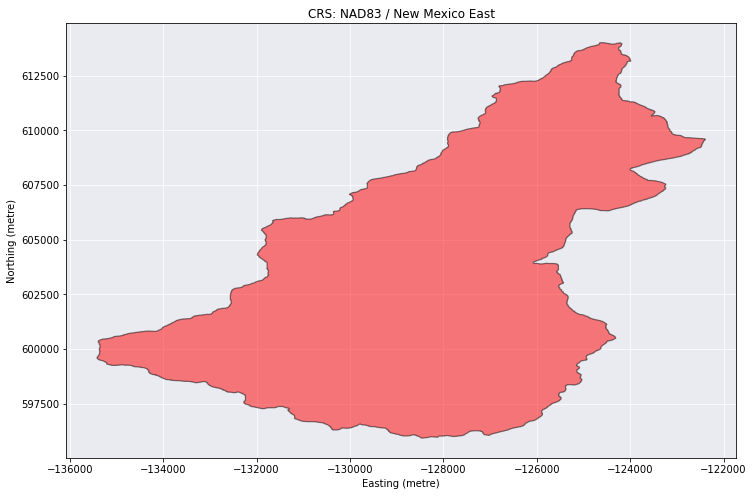

In [25]:
dem.get_boundary().plot()